<a href="https://colab.research.google.com/github/afhabibieee/closing-price-BBRIJK-univariate/blob/main/closingprice_BBRIJK_univariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objectives



> Menggunakan variable close price (univariate) yang outcomes-nya prediksi closing price untuk 5 hari kedepan (satu minggu)



## Install Required Library

In [ ]:
!pip install yfinance --upgrade --no-cache-dir #(For pip)

     |████████████████████████████████| 6.4 MB 51.7 MB/s 
     |████████████████████████████████| 63 kB 47.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install --upgrade mplfinance

     |████████████████████████████████| 64 kB 2.6 MB/s 


## Collecting Data

In [ ]:
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [ ]:
start = '2003-11-10'
end = '2022-01-07'

data = pdr.get_data_yahoo(
    tickers='BBRI.JK',
    start=start,
    end= end
)

[*********************100%***********************]  1 of 1 completed


## Data Preprocessing

In [ ]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-11-10,105.0,110.0,95.0,97.5,58.935913,5144140000
2003-11-11,97.5,100.0,95.0,100.0,60.447098,2938555000
2003-11-12,97.5,105.0,97.5,105.0,63.469444,2002915000
2003-11-13,105.0,105.0,102.5,105.0,63.469444,1190050000
2003-11-14,105.0,105.0,100.0,105.0,63.469444,1725265000
...,...,...,...,...,...,...
2021-12-30,4080.0,4140.0,4060.0,4110.0,4110.000000,146989400
2022-01-03,4120.0,4190.0,4090.0,4180.0,4180.000000,90842500
2022-01-04,4200.0,4210.0,4160.0,4160.0,4160.000000,93950000


In [ ]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

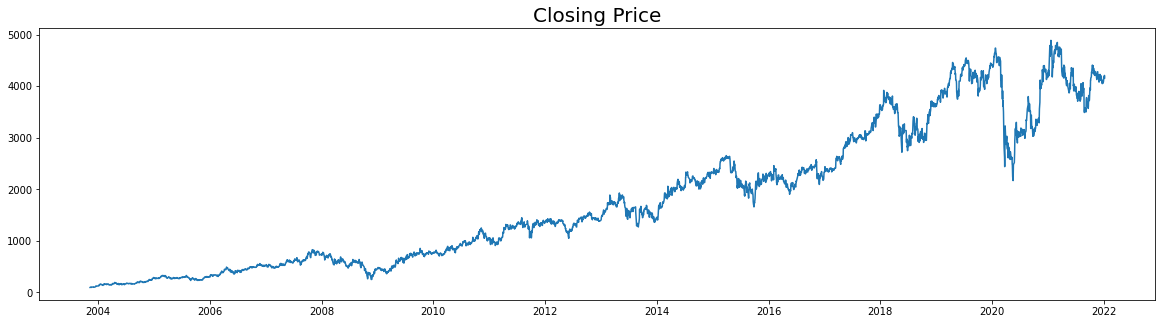

In [ ]:
import matplotlib.pyplot as plt

dates = data.index
close  = data['Close'].values
 
_ = plt.figure(figsize=(20,5))
_ = plt.plot(dates, close)
_ = plt.title('Closing Price', fontsize=20)
_ = plt.plot()

In [ ]:
# Normalisasi features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
close = scaler.fit_transform(close.reshape(-1,1))

In [ ]:
close

array([[0.00000000e+00],
       [5.21648409e-04],
       [1.56494523e-03],
       ...,
       [8.47678665e-01],
       [8.58111633e-01],
       [8.47678665e-01]])

In [ ]:
import pandas as pd

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  """ Fungsi ini dibuat untuk membentuk supervised (yang terdapat nilai target)
      
      parameter :

      - data, baik belum atau sudah di normalisasi
      - n_in atau time steps : jumlah langkah mundur (hari)/ time steps 
                               sebagai input untuk prediksi 
      - n_out atau future time steps : jumlah langkah maju (hari) yang
                                       nilainya diprediksi sebagai target

      return :

      dataframe dengan sejumlah n features (n: jumlah timesteps) 
      dan target sejumlah hari / future time steps sesuai dengan column target.
  """
  
  # univariate
  n_vars = 1

  df = pd.DataFrame(data)
  cols, col_names = [], []

  # buat features
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    col_names += ['Closing Price Feature(t-%d)'%(i)]
  
  # buat target
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      col_names += ['Closing Price Target(t)']
    else:
      col_names += ['Closing Price Target(t+{})'.format(i)]
  
  df = pd.concat(cols, axis=1)
  df.columns = col_names

  if dropnan:
    df.dropna(inplace=True)
  
  return df

In [ ]:
# Config

timeSteps=10        # 10 hari terakhir sebagai input (dua minggu)
futureTimeSteps=5   # prediksi 5 hari ke depan (satu minggu)
n_features = close.shape[1]
n_observe = timeSteps * n_features    # jumlah feature series to supervised

In [ ]:
# bentuk menjadi dataframe series to supervised

data_supervised = series_to_supervised(close, timeSteps, futureTimeSteps)
data_supervised.head()

,Closing Price Feature(t-10),Closing Price Feature(t-9),Closing Price Feature(t-8),Closing Price Feature(t-7),Closing Price Feature(t-6),Closing Price Feature(t-5),Closing Price Feature(t-4),Closing Price Feature(t-3),Closing Price Feature(t-2),Closing Price Feature(t-1),Closing Price Target(t),Closing Price Target(t+1),Closing Price Target(t+2),Closing Price Target(t+3),Closing Price Target(t+4)
10,0.000000,0.000522,0.001565,0.001565,0.001565,0.000522,0.000000,0.000522,0.001043,0.001565,0.001565,0.001565,0.001565,0.001565,0.001565
11,0.000522,0.001565,0.001565,0.001565,0.000522,0.000000,0.000522,0.001043,0.001565,0.001565,0.001565,0.001565,0.001565,0.001565,0.002087
12,0.001565,0.001565,0.001565,0.000522,0.000000,0.000522,0.001043,0.001565,0.001565,0.001565,0.001565,0.001565,0.001565,0.002087,0.001565
13,0.001565,0.001565,0.000522,0.000000,0.000522,0.001043,0.001565,0.001565,0.001565,0.001565,0.001565,0.001565,0.002087,0.001565,0.001043
14,0.001565,0.000522,0.000000,0.000522,0.001043,0.001565,0.001565,0.001565,0.001565,0.001565,0.001565,0.002087,0.001565,0.001043,0.001565


In [ ]:
# bagi data feature dan target

X = data_supervised.values[:, :n_observe]
y = data_supervised.values[:, n_observe:]

In [ ]:
# Siapkan data untuk dilatih dan divalidasi (20%)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  shuffle=False)

In [ ]:
len(y), y_train.shape, y_val.shape

(4504, (3603, 5), (901, 5))

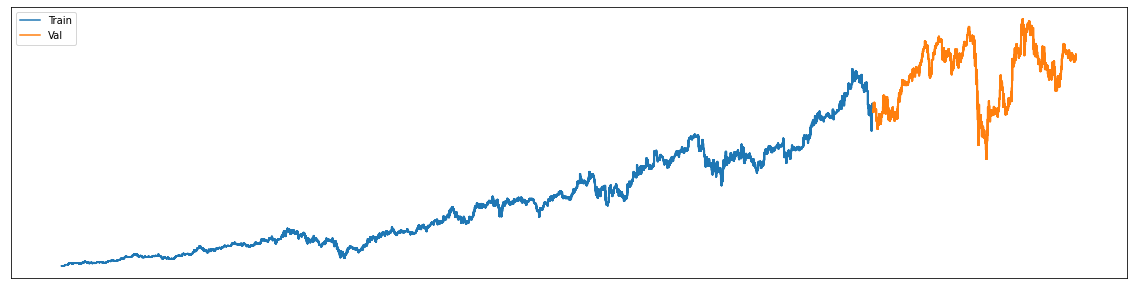

In [ ]:
# plot pembagian data (20% validasi)
plt.figure(figsize=(20, 5))
plt.plot(y_train.reshape(-1,))
plt.plot([None for i in y_train.reshape(-1,)] + [j for j in y_val.reshape(-1,)])
plt.legend(('Train', 'Val'), loc='best')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# reshape input untuk lstm model

X_train = X_train.reshape(X_train.shape[0], timeSteps, n_features)
X_val = X_val.reshape(X_val.shape[0], timeSteps, n_features)

In [ ]:
# jumlah rows dari data training, jumlah timestamp, jumlah feature
print(X_train.shape, X_val.shape)

(3603, 10, 1) (901, 10, 1)


## Modeling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# buat model
def build_model():
    m = Sequential([
                    LSTM(64, input_shape=(timeSteps, n_features), return_sequences=True),
                    LSTM(32, dropout=0.4),
    #                Dense(64, 'relu'),
    #                Dropout(0.3),
    #                Dense(32, 'relu'),
                    Dense(futureTimeSteps)
    ])
    m.compile(loss='mse', optimizer=Adam(learning_rate=3e-5), metrics='mae')
    return m

In [ ]:
from tensorflow.keras.callbacks import  EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               mode='min')

In [ ]:
model_lstm = build_model()

history = model_lstm.fit(
    X_train, y_train, validation_data=(X_val, y_val),
    epochs=100, shuffle=False,
    callbacks=[early_stopping]
)

Epoch 1/100
113/113 [==============================] - 6s 21ms/step - loss: 0.0570 - mae: 0.1908 - val_loss: 0.3165 - val_mae: 0.5474
Epoch 2/100
113/113 [==============================] - 1s 13ms/step - loss: 0.0333 - mae: 0.1349 - val_loss: 0.1999 - val_mae: 0.4268
Epoch 3/100
113/113 [==============================] - 1s 13ms/step - loss: 0.0179 - mae: 0.0988 - val_loss: 0.1081 - val_mae: 0.3025
Epoch 4/100
113/113 [==============================] - 2s 13ms/step - loss: 0.0098 - mae: 0.0787 - val_loss: 0.0545 - val_mae: 0.2073
Epoch 5/100
113/113 [==============================] - 1s 13ms/step - loss: 0.0067 - mae: 0.0686 - val_loss: 0.0291 - val_mae: 0.1489
Epoch 6/100
113/113 [==============================] - 1s 13ms/step - loss: 0.0052 - mae: 0.0610 - val_loss: 0.0170 - val_mae: 0.1123
Epoch 7/100
113/113 [==============================] - 1s 13ms/step - loss: 0.0042 - mae: 0.0547 - val_loss: 0.0107 - val_mae: 0.0879
Epoch 8/100
113/113 [==============================] - 1s 13ms

## Evaluation

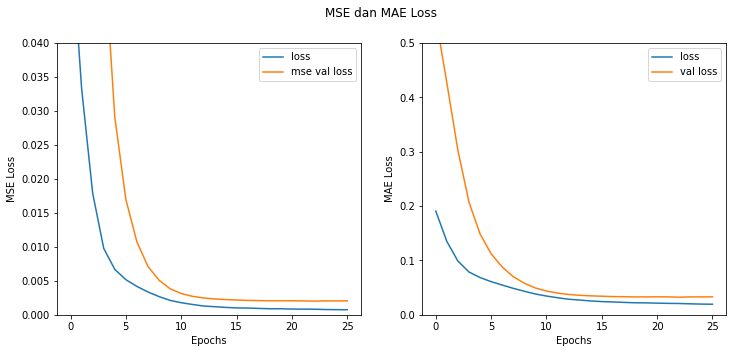

In [ ]:
# ploting loss

fig, axs = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('MSE dan MAE Loss')

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='mse val loss')
axs[0].set_ylabel('MSE Loss')
axs[0].set_xlabel('Epochs')
axs[0].legend()
axs[0].set_ylim([0, 0.04])

axs[1].plot(history.history['mae'], label='loss')
axs[1].plot(history.history['val_mae'], label='val loss')
axs[1].set_ylabel('MAE Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()
axs[1].set_ylim([0, 0.5])

fig.show()

In [ ]:
# MSE dan MAE daei train dan val
print('Train, MSE: {}, MAE: {}'.format(model_lstm.evaluate(X_train, y_train, verbose=0)[0],
                                            model_lstm.evaluate(X_train, y_train, verbose=0)[1]))
print('Val, MSE: {}, MAE: {}'.format(model_lstm.evaluate(X_val, y_val, verbose=0)[0],
                                          model_lstm.evaluate(X_val, y_val, verbose=0)[1]))

Train, MSE: 0.00028539495542645454, MAE: 0.012359433807432652
Val, MSE: 0.002047414192929864, MAE: 0.03301858529448509


In [ ]:
# Hitung r2 score dari data validasi
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

y_val_pred_lstm = model_lstm.predict(X_val)

r2 = r2_score(y_val, y_val_pred_lstm)
rmse = sqrt(mean_squared_error(y_val, y_val_pred_lstm))
print('Test r2 score: {}'.format(r2))
print('Test rmse: {}'.format(rmse))

Test r2 score: 0.8547912441843968
Test rmse: 0.04524836424335187
